# Experimentación - DCRNN

https://arxiv.org/abs/1707.01926

## 1. Obtención de datos



In [2]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [57]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
name_model = "DCRNN"
results_save_path = "./results"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch


from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerDCRNN
from utils.models import DCRNNModel
dtype = torch.float
device = torch.device("cpu")

## Prueba - predicción por tipos

In [14]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 0
num_epochs = 50
lr = 0.01

In [51]:
import itertools


def entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]


    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden_size in tqdm(list(param_grid["hidden_size"])):
        

        model = DCRNNModel(name="DCRNN", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_dim=hidden_size)
        device =  torch.device("cpu")

        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params)


        losses,eval_losses, r2scores  = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer.test()

        results_intermedio = {
            "Embedding": hidden_size,
            "Loss_final": losses[-1],
            "R2_eval": np.mean(r2scores[-1]),
            "Loss_eval": np.mean(eval_losses[-1]),
            "R2_tst": np.mean(r2score_tst),
            "Loss_tst": np.mean(losses_tst),
            "Loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden_size}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden_size)
        print("Resultados: ", resultados_list[-1])

    resultados = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados


### Gen trip

In [15]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [16]:

n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =32

#### Sencilla 

In [17]:
model_gt = DCRNNModel(name="DCRNN", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_dim=hidden_size)
device =  torch.device("cpu")

model_gt.to(device)
trainer_gt = TrainerDCRNN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5887 | Eval Loss: 0.2546 | Eval R2: -109.3517 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.1560 | Eval Loss: 0.0920 | Eval R2: -28.4283 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.0810 | Eval Loss: 0.0673 | Eval R2: -17.4625 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0692 | Eval Loss: 0.0609 | Eval R2: -15.6218 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0623 | Eval Loss: 0.0540 | Eval R2: -13.8099 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0542 | Eval Loss: 0.0456 | Eval R2: -11.6639 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0449 | Eval Loss: 0.0376 | Eval R2: -10.0473 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0369 | Eval Loss: 0.0315 | Eval R2: -8.9087 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0305 | Eval Loss: 0.0266 | Eval R2: -7.8492 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0256 | Ev

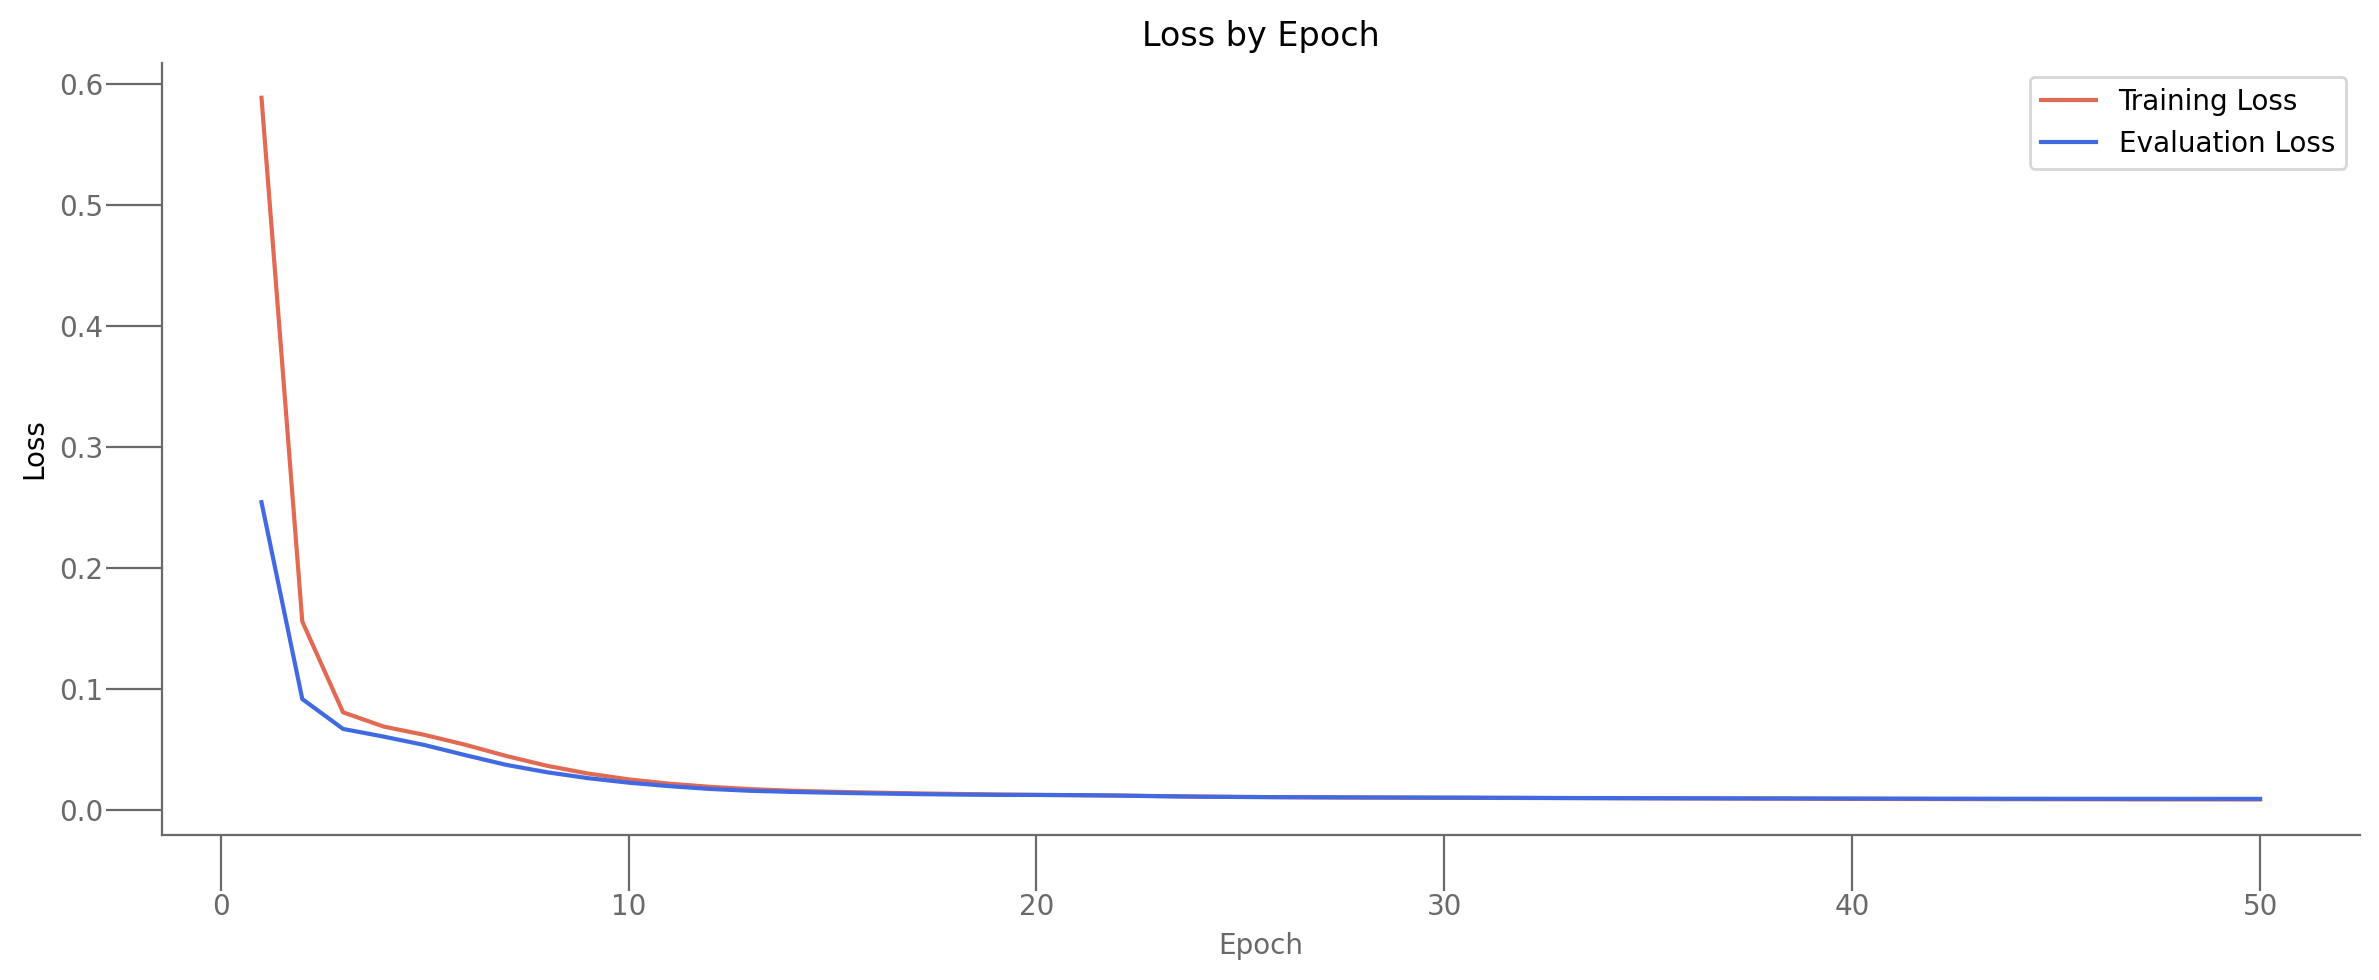


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006968, test R2 score: -1.603802


In [18]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()



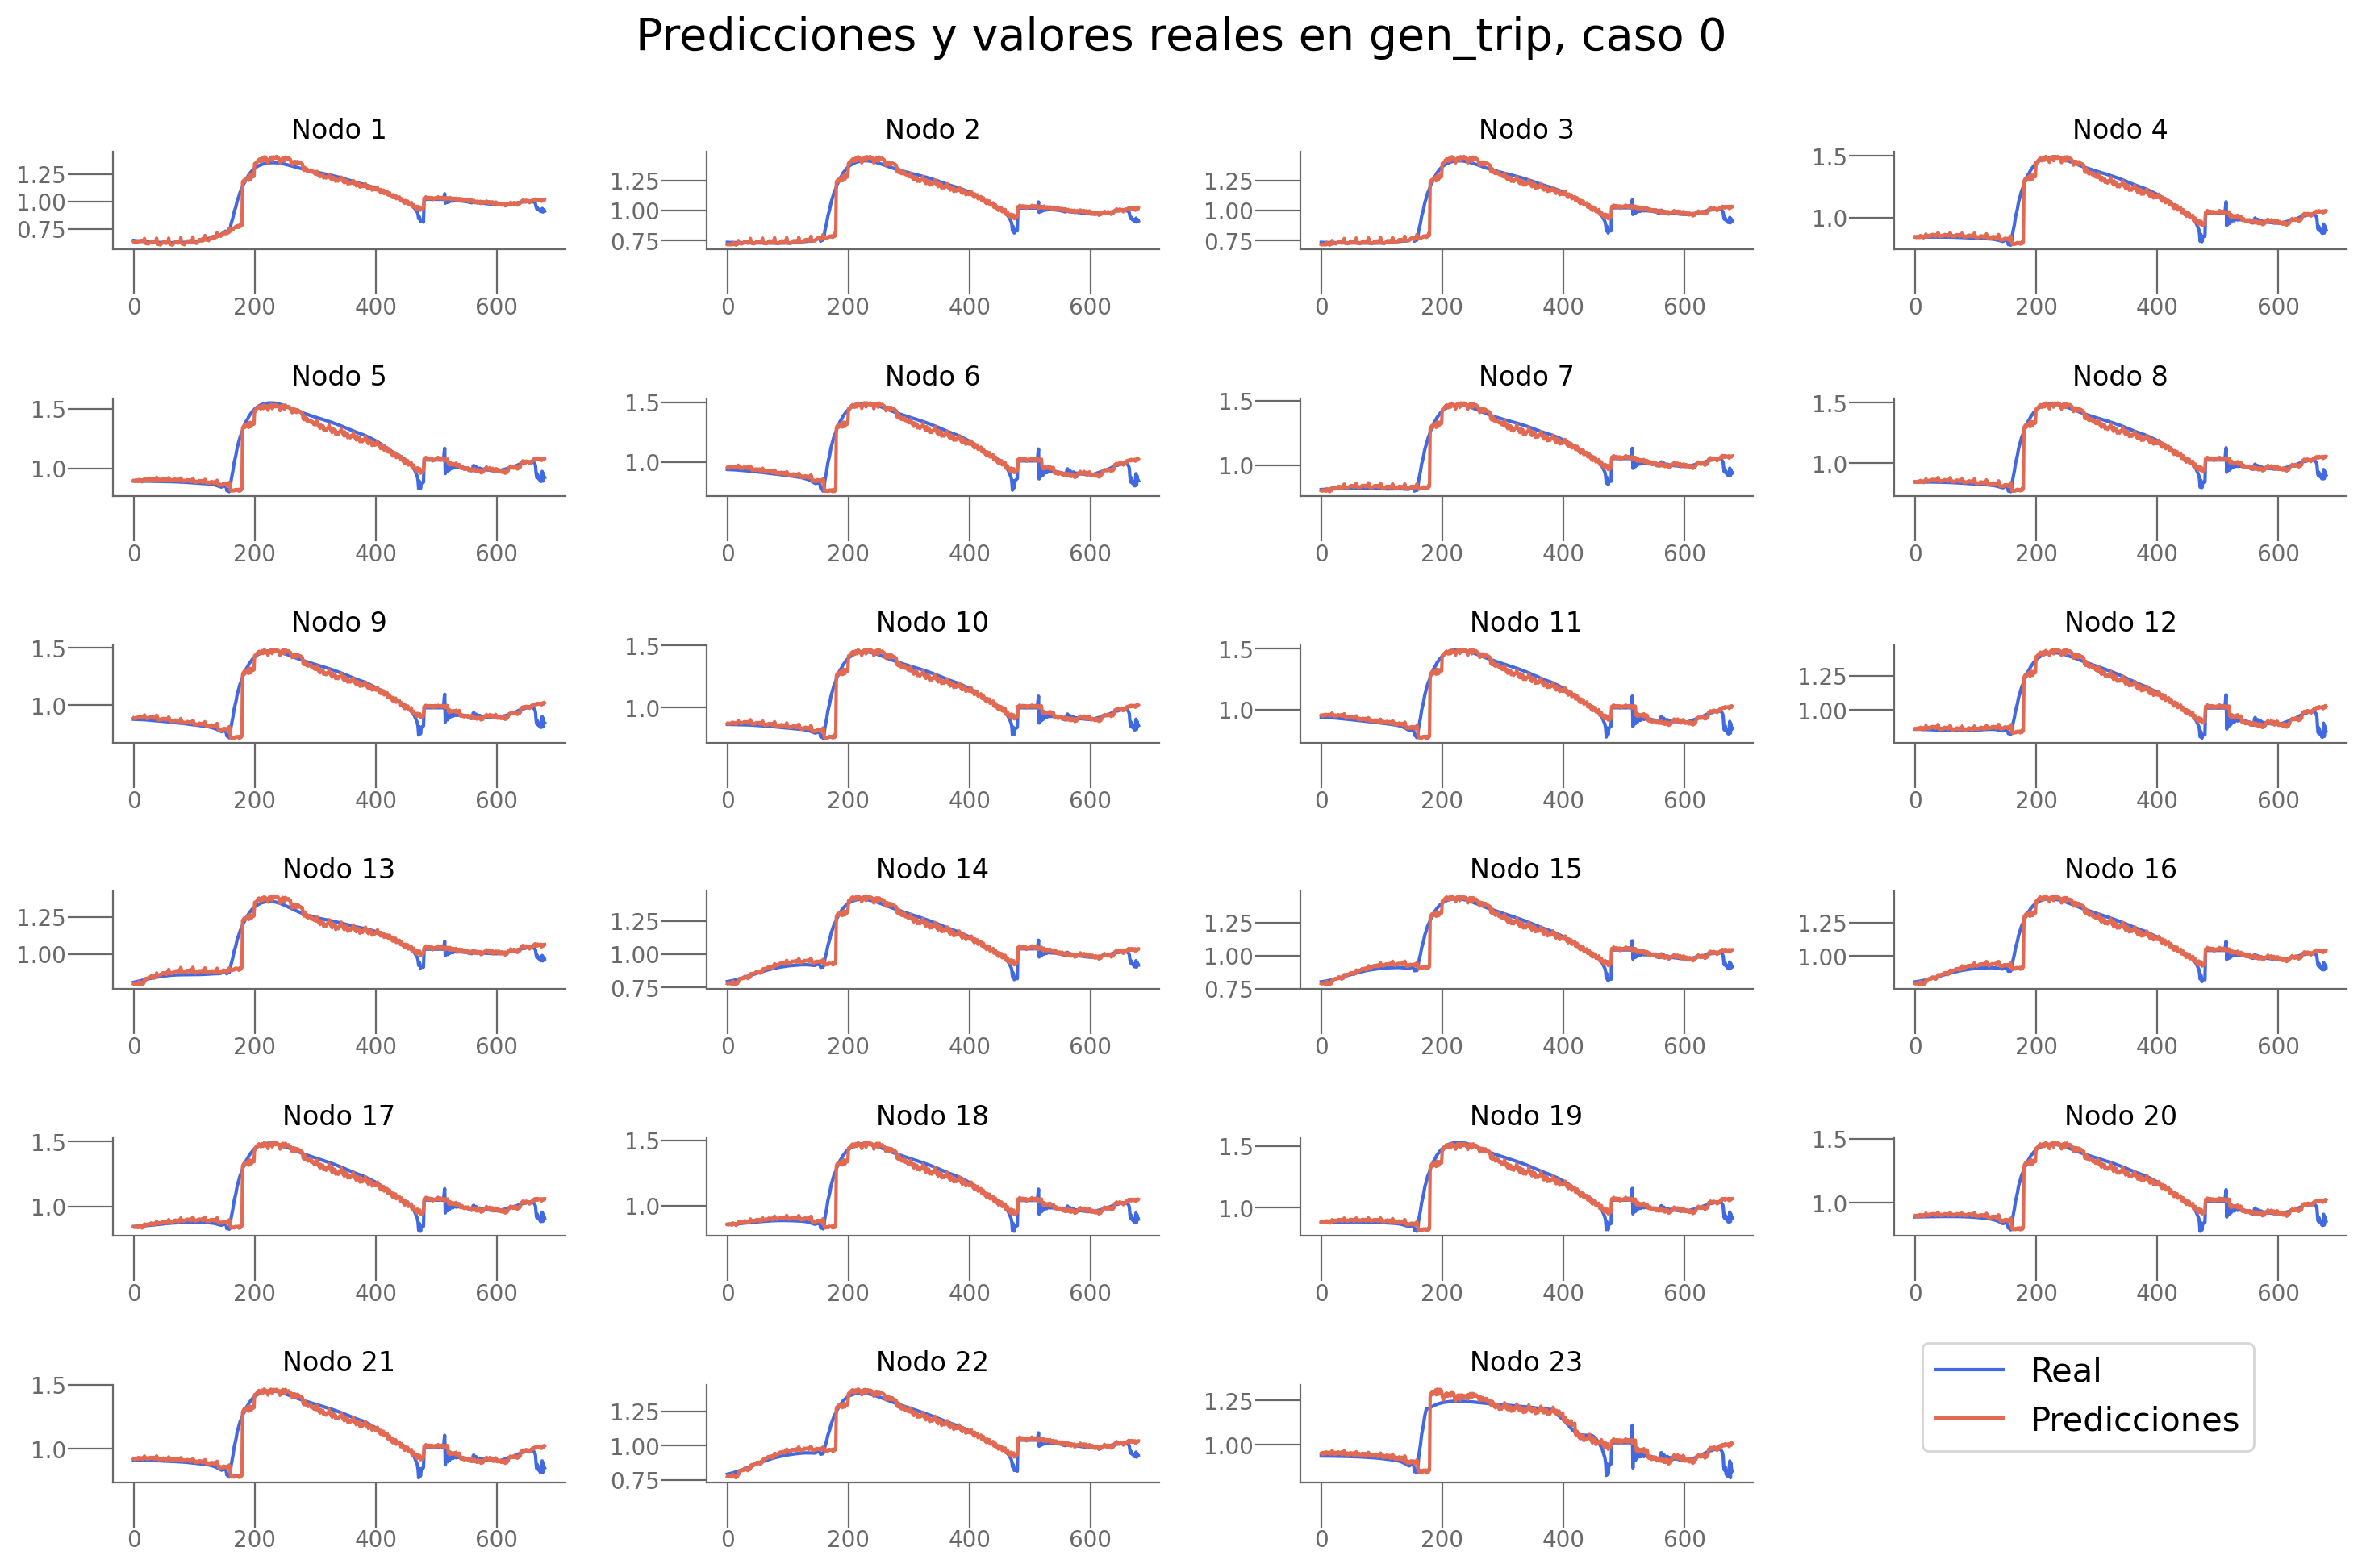

In [19]:
plot_predictions(predictions_gt, real_gt, n_target, 0, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [27]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5080 | Eval Loss: 0.2118 | Eval R2: -89.5111 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.1221 | Eval Loss: 0.0696 | Eval R2: -21.4536 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.0536 | Eval Loss: 0.0391 | Eval R2: -10.2027 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0346 | Eval Loss: 0.0278 | Eval R2: -6.8484 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0254 | Eval Loss: 0.0211 | Eval R2: -5.3273 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0202 | Eval Loss: 0.0174 | Eval R2: -4.3231 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0171 | Eval Loss: 0.0152 | Eval R2: -3.5596 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0153 | Eval Loss: 0.0138 | Eval R2: -3.2294 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0141 | Eval Loss: 0.0129 | Eval R2: -2.9954 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0131 | Eval Lo

 25%|██▌       | 1/4 [03:13<09:41, 193.73s/it]

preds:  (1, 23, 20)
test loss: 0.006898, test R2 score: -1.667993
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.008212880231440067, 'R2_eval': -1.549892783164978, 'Loss_eval': 0.009214475750923157, 'R2_tst': -1.6679925084686857, 'Loss_tst': 0.0068975938484072685, 'Loss_nodes': [[0.0019146326230838895, 0.003743845270946622, 0.004706668201833963, 0.0026437060441821814, 0.008069977164268494, 0.004081367049366236, 0.0037524935323745012, 0.004897300153970718, 0.004979592747986317, 0.005073912441730499, 0.00508471205830574, 0.007164624985307455, 0.008102607913315296, 0.00925816036760807, 0.009180639870464802, 0.008533480577170849, 0.013070184737443924, 0.010816185735166073, 0.00970594771206379, 0.013171817176043987]]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5593 | Eval Loss: 0.2592 | Eval R2: -109.0540 | LR: 0.0010 | 


 50%|█████     | 2/4 [06:09<06:05, 182.91s/it]

preds:  (1, 23, 20)
test loss: 0.006949, test R2 score: -1.704541
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.008757339790463448, 'R2_eval': -1.5932894945144653, 'Loss_eval': 0.009400608949363232, 'R2_tst': -1.7045405447495123, 'Loss_tst': 0.006948938127607107, 'Loss_nodes': [[0.0019030554685741663, 0.0037804157473146915, 0.004950054455548525, 0.0027625656221061945, 0.008122761733829975, 0.004378148820251226, 0.004022564738988876, 0.004906365182250738, 0.005138958804309368, 0.005306298844516277, 0.004688198212534189, 0.00700546707957983, 0.007750365417450666, 0.009042588993906975, 0.009215004742145538, 0.00859312154352665, 0.012939322739839554, 0.011259231716394424, 0.009869342669844627, 0.01334493700414896]]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.2920 | Eval Loss: 0.0663 | Eval R2: -17.6924 | LR: 0.0010 | 
E

 75%|███████▌  | 3/4 [09:21<03:07, 187.31s/it]

preds:  (1, 23, 20)
test loss: 0.007293, test R2 score: -2.041025
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.008074481971561909, 'R2_eval': -1.850043535232544, 'Loss_eval': 0.00971291121095419, 'R2_tst': -2.0410251034885287, 'Loss_tst': 0.007293247152119875, 'Loss_nodes': [[0.0019607986323535442, 0.004174965899437666, 0.00442353542894125, 0.0030487687326967716, 0.008212033659219742, 0.004178029019385576, 0.004197810310870409, 0.005397274624556303, 0.0050544096156954765, 0.005991864018142223, 0.0050220494158566, 0.007775100879371166, 0.008818337693810463, 0.009803215973079205, 0.010191471315920353, 0.008673734031617641, 0.013613030314445496, 0.011085201054811478, 0.010023250244557858, 0.014220076613128185]]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.1814 | Eval Loss: 0.0502 | Eval R2: -13.0396 | LR: 0.0010 | 
Epo

100%|██████████| 4/4 [12:39<00:00, 189.81s/it]

preds:  (1, 23, 20)
test loss: 0.007810, test R2 score: -2.422457
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.007629462517797947, 'R2_eval': -2.142382860183716, 'Loss_eval': 0.010261769406497478, 'R2_tst': -2.4224573849014015, 'Loss_tst': 0.007809814997017384, 'Loss_nodes': [[0.002941273618489504, 0.005372240208089352, 0.0046060713939368725, 0.0036138384602963924, 0.008341196924448013, 0.004342778120189905, 0.004445801489055157, 0.005747990682721138, 0.005426608491688967, 0.006142802536487579, 0.005518537480384111, 0.008353780955076218, 0.0088457390666008, 0.010164076462388039, 0.009773604571819305, 0.009408976882696152, 0.0156411062926054, 0.01167726144194603, 0.010666940361261368, 0.015165641903877258]]}


In [59]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006898, test R2 score: -1.667993


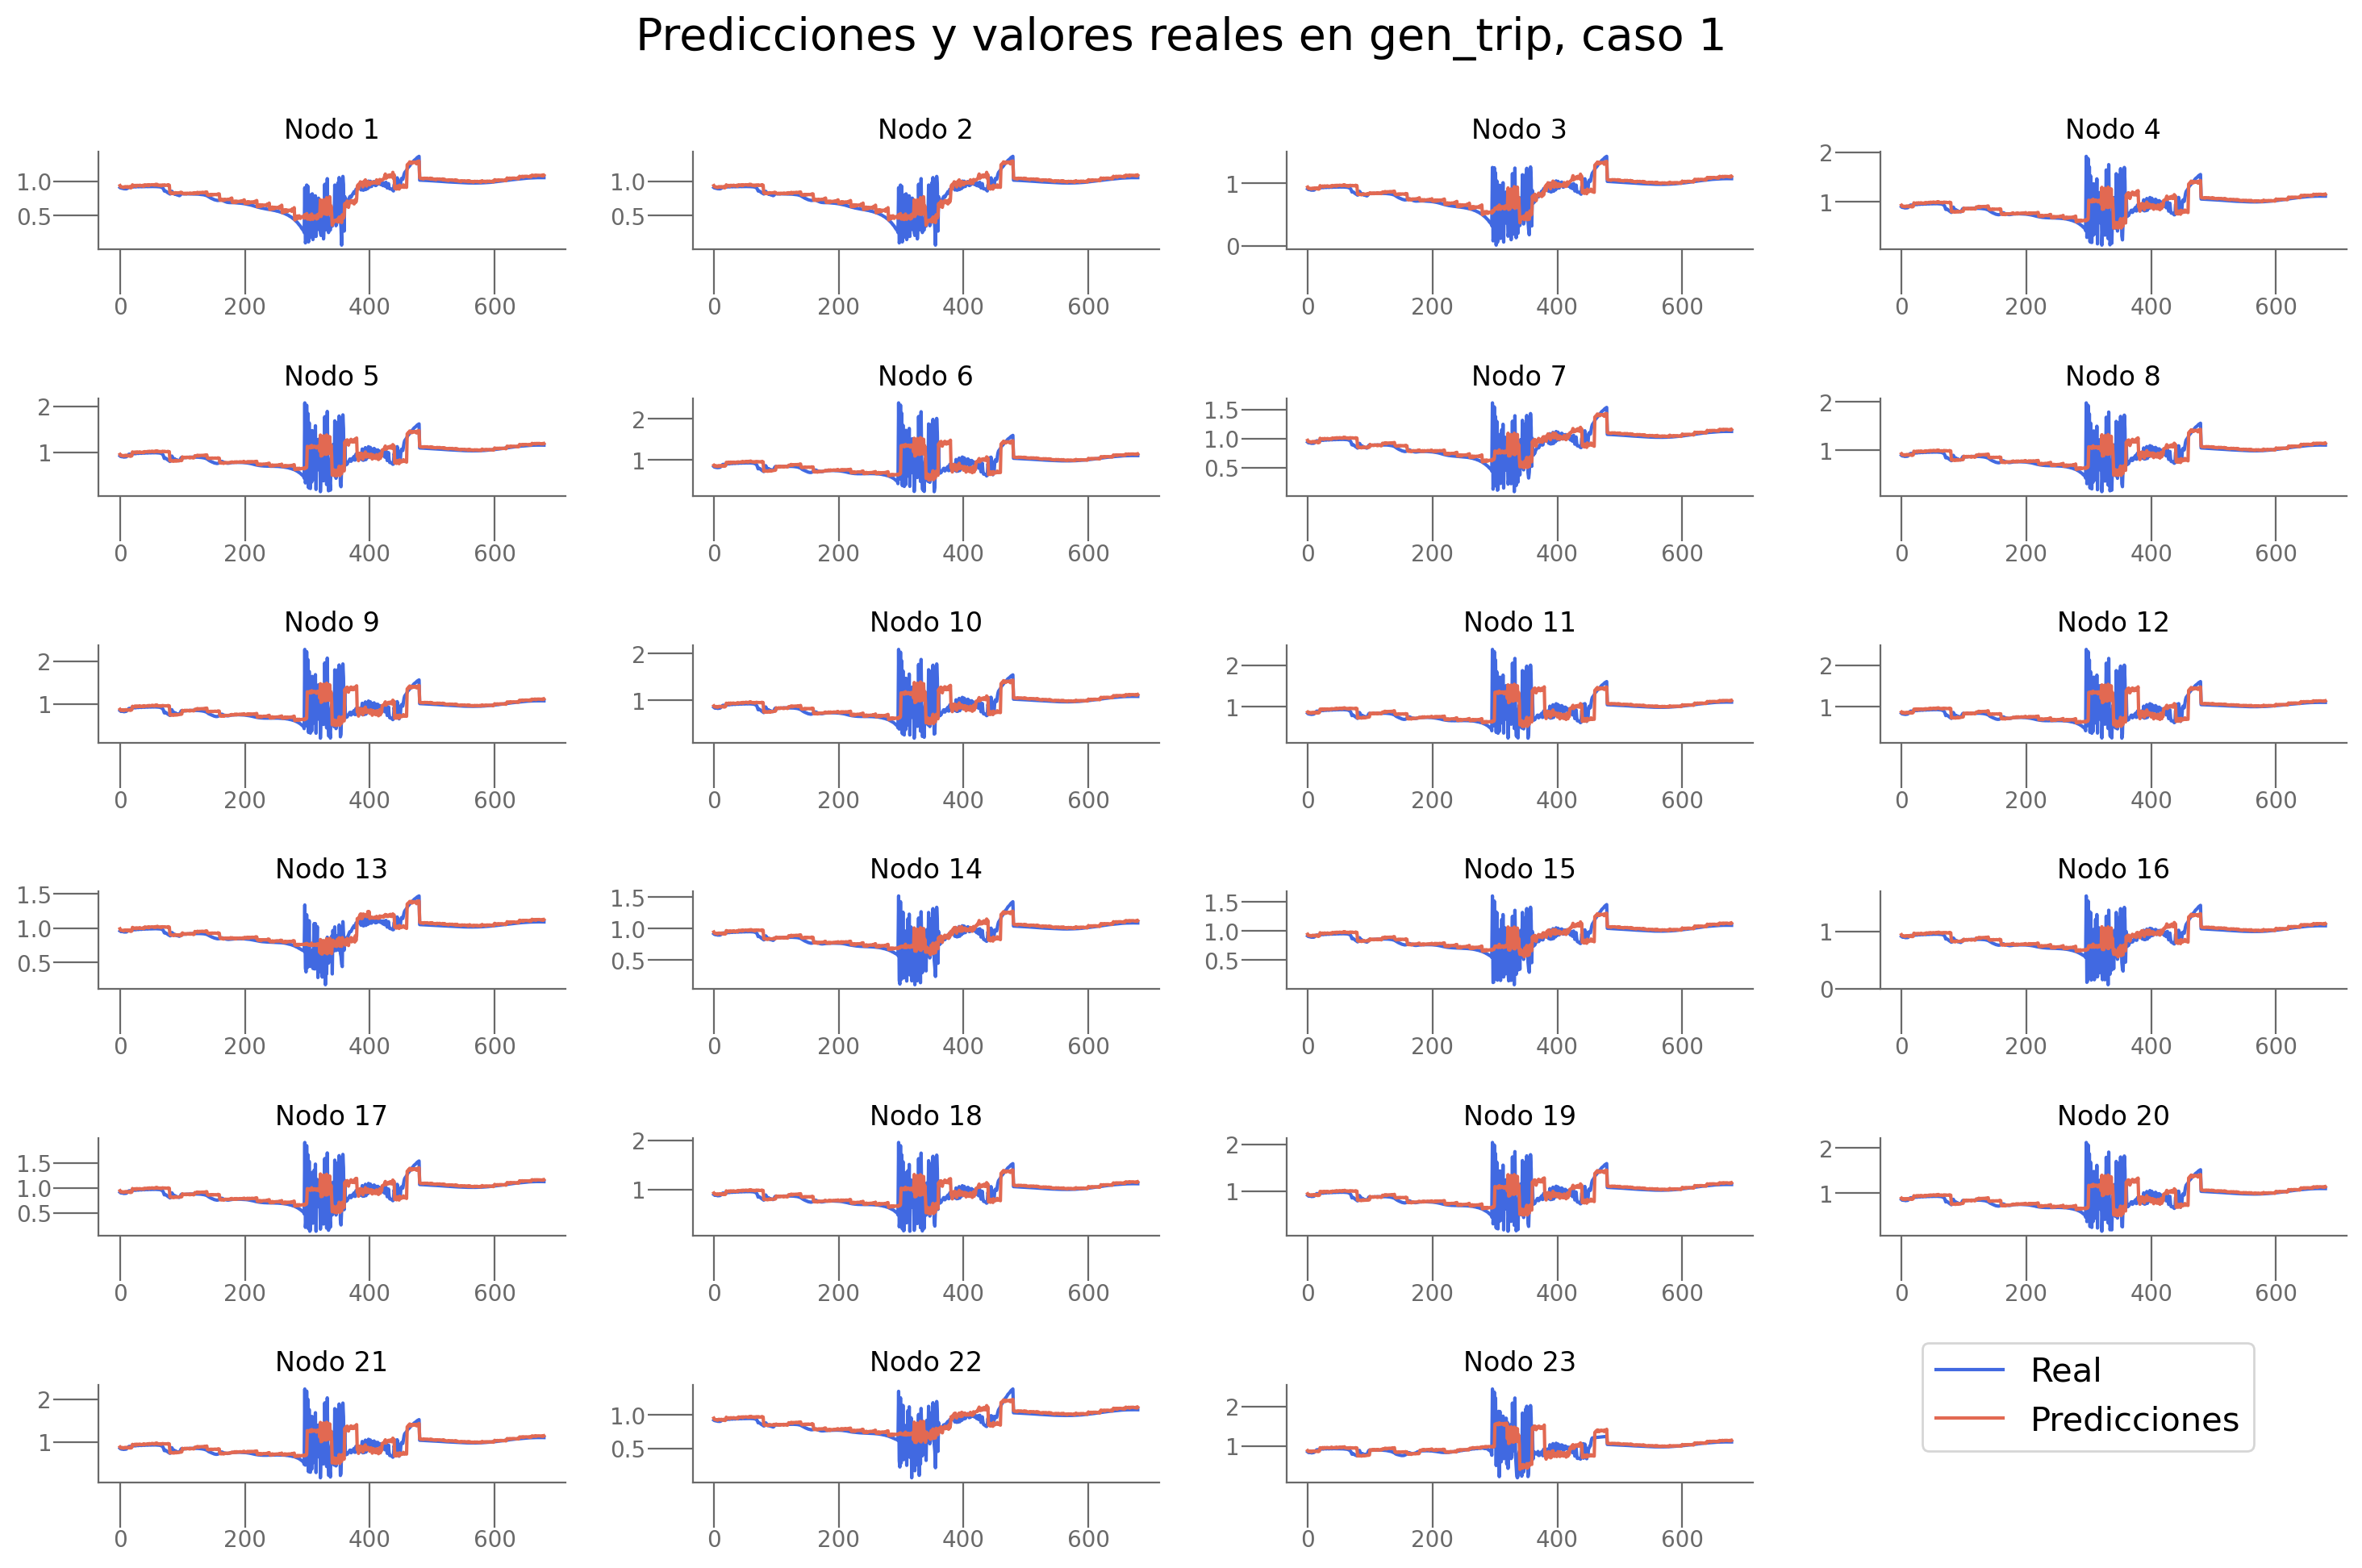

In [31]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [44]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6     EvolveGCN                                                NaN   
7         DCRNN                                     {'hidden': 10}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579 

### Bus trip

In [33]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [34]:

n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [35]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_bt,params_bt, resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.6426 | Eval Loss: 0.4158 | Eval R2: -13.1233 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.2941 | Eval Loss: 0.1926 | Eval R2: -5.0360 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.1420 | Eval Loss: 0.0970 | Eval R2: -1.6671 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0783 | Eval Loss: 0.0581 | Eval R2: -0.3923 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0517 | Eval Loss: 0.0429 | Eval R2: 0.0487 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0384 | Eval Loss: 0.0341 | Eval R2: 0.3046 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0303 | Eval Loss: 0.0268 | Eval R2: 0.4801 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0255 | Eval Loss: 0.0225 | Eval R2: 0.5637 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0220 | Eval Loss: 0.0194 | Eval R2: 0.6137 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0191 | Eval Loss: 0.0

 25%|██▌       | 1/4 [01:26<04:18, 86.17s/it]

preds:  (1, 23, 20)
test loss: 0.006046, test R2 score: 0.857301
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.005591494031250477, 'R2_eval': 0.8696617484092712, 'Loss_eval': 0.005720982793718576, 'R2_tst': 0.8573007295034213, 'Loss_tst': 0.006045772228389978, 'Loss_nodes': [[0.0019471530104056, 0.002517210552468896, 0.0026005276013165712, 0.0024732029996812344, 0.006114784628152847, 0.0034801641013473272, 0.003499247133731842, 0.004189321771264076, 0.005076464265584946, 0.005053229629993439, 0.005823572166264057, 0.005394016858190298, 0.0070452457293868065, 0.00694228382781148, 0.007952539250254631, 0.009251865558326244, 0.009131962433457375, 0.010265346616506577, 0.010668477043509483, 0.011488844640552998]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.7131 | Eval Loss: 0.4944 | Eval R2: -15.3637 | LR: 0.0010 | 
Epo

 50%|█████     | 2/4 [02:48<02:48, 84.06s/it]

preds:  (1, 23, 20)
test loss: 0.005762, test R2 score: 0.865418
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.005348728038370609, 'R2_eval': 0.8740507364273071, 'Loss_eval': 0.005551697686314583, 'R2_tst': 0.8654183756009352, 'Loss_tst': 0.005762149579823017, 'Loss_nodes': [[0.0021628784015774727, 0.0027272433508187532, 0.0025431723333895206, 0.002580986823886633, 0.0033041161950677633, 0.003342339303344488, 0.0037002034951001406, 0.0040922691114246845, 0.0044268351048231125, 0.0047514489851891994, 0.005309884436428547, 0.0059623378328979015, 0.006602205336093903, 0.006709230598062277, 0.007664134725928307, 0.00866535771638155, 0.008650073781609535, 0.01142710167914629, 0.009818986058235168, 0.010802170261740685]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5003 | Eval Loss: 0.1879 | Eval R2: -4.7274 | LR: 0.0010 |

 75%|███████▌  | 3/4 [04:14<01:24, 84.87s/it]

preds:  (1, 23, 20)
test loss: 0.004989, test R2 score: 0.881835
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.004688760731369257, 'R2_eval': 0.890032947063446, 'Loss_eval': 0.004830739460885525, 'R2_tst': 0.8818349460833281, 'Loss_tst': 0.004989001899957657, 'Loss_nodes': [[0.0012790734181180596, 0.0021986989304423332, 0.002018167171627283, 0.0019593352917581797, 0.0024781585671007633, 0.0027503129094839096, 0.0030665788799524307, 0.0033187721855938435, 0.0037574307061731815, 0.004315285477787256, 0.004207785706967115, 0.005049203522503376, 0.005956350825726986, 0.0063802823424339294, 0.006904144771397114, 0.007393424864858389, 0.00805574283003807, 0.009139814414083958, 0.009413526393473148, 0.0101379519328475]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.3231 | Eval Loss: 0.0595 | Eval R2: -0.4658 | LR: 0.0010 | 


100%|██████████| 4/4 [05:44<00:00, 86.15s/it]

preds:  (1, 23, 20)
test loss: 0.004495, test R2 score: 0.889230
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.004135207738727331, 'R2_eval': 0.8985251784324646, 'Loss_eval': 0.004250011872500181, 'R2_tst': 0.8892304705742348, 'Loss_tst': 0.00449511781334877, 'Loss_nodes': [[0.0007861914928071201, 0.0015820841072127223, 0.001583655714057386, 0.0015189442783594131, 0.002229747362434864, 0.0022390258964151144, 0.002665445674210787, 0.002724242163822055, 0.0031526307575404644, 0.0036699871998280287, 0.0038276691921055317, 0.004440564662218094, 0.005592293571680784, 0.005751766264438629, 0.006550670135766268, 0.006954222917556763, 0.007705525495111942, 0.008657594211399555, 0.00876865815371275, 0.009501434862613678]]}


In [58]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004495, test R2 score: 0.889230


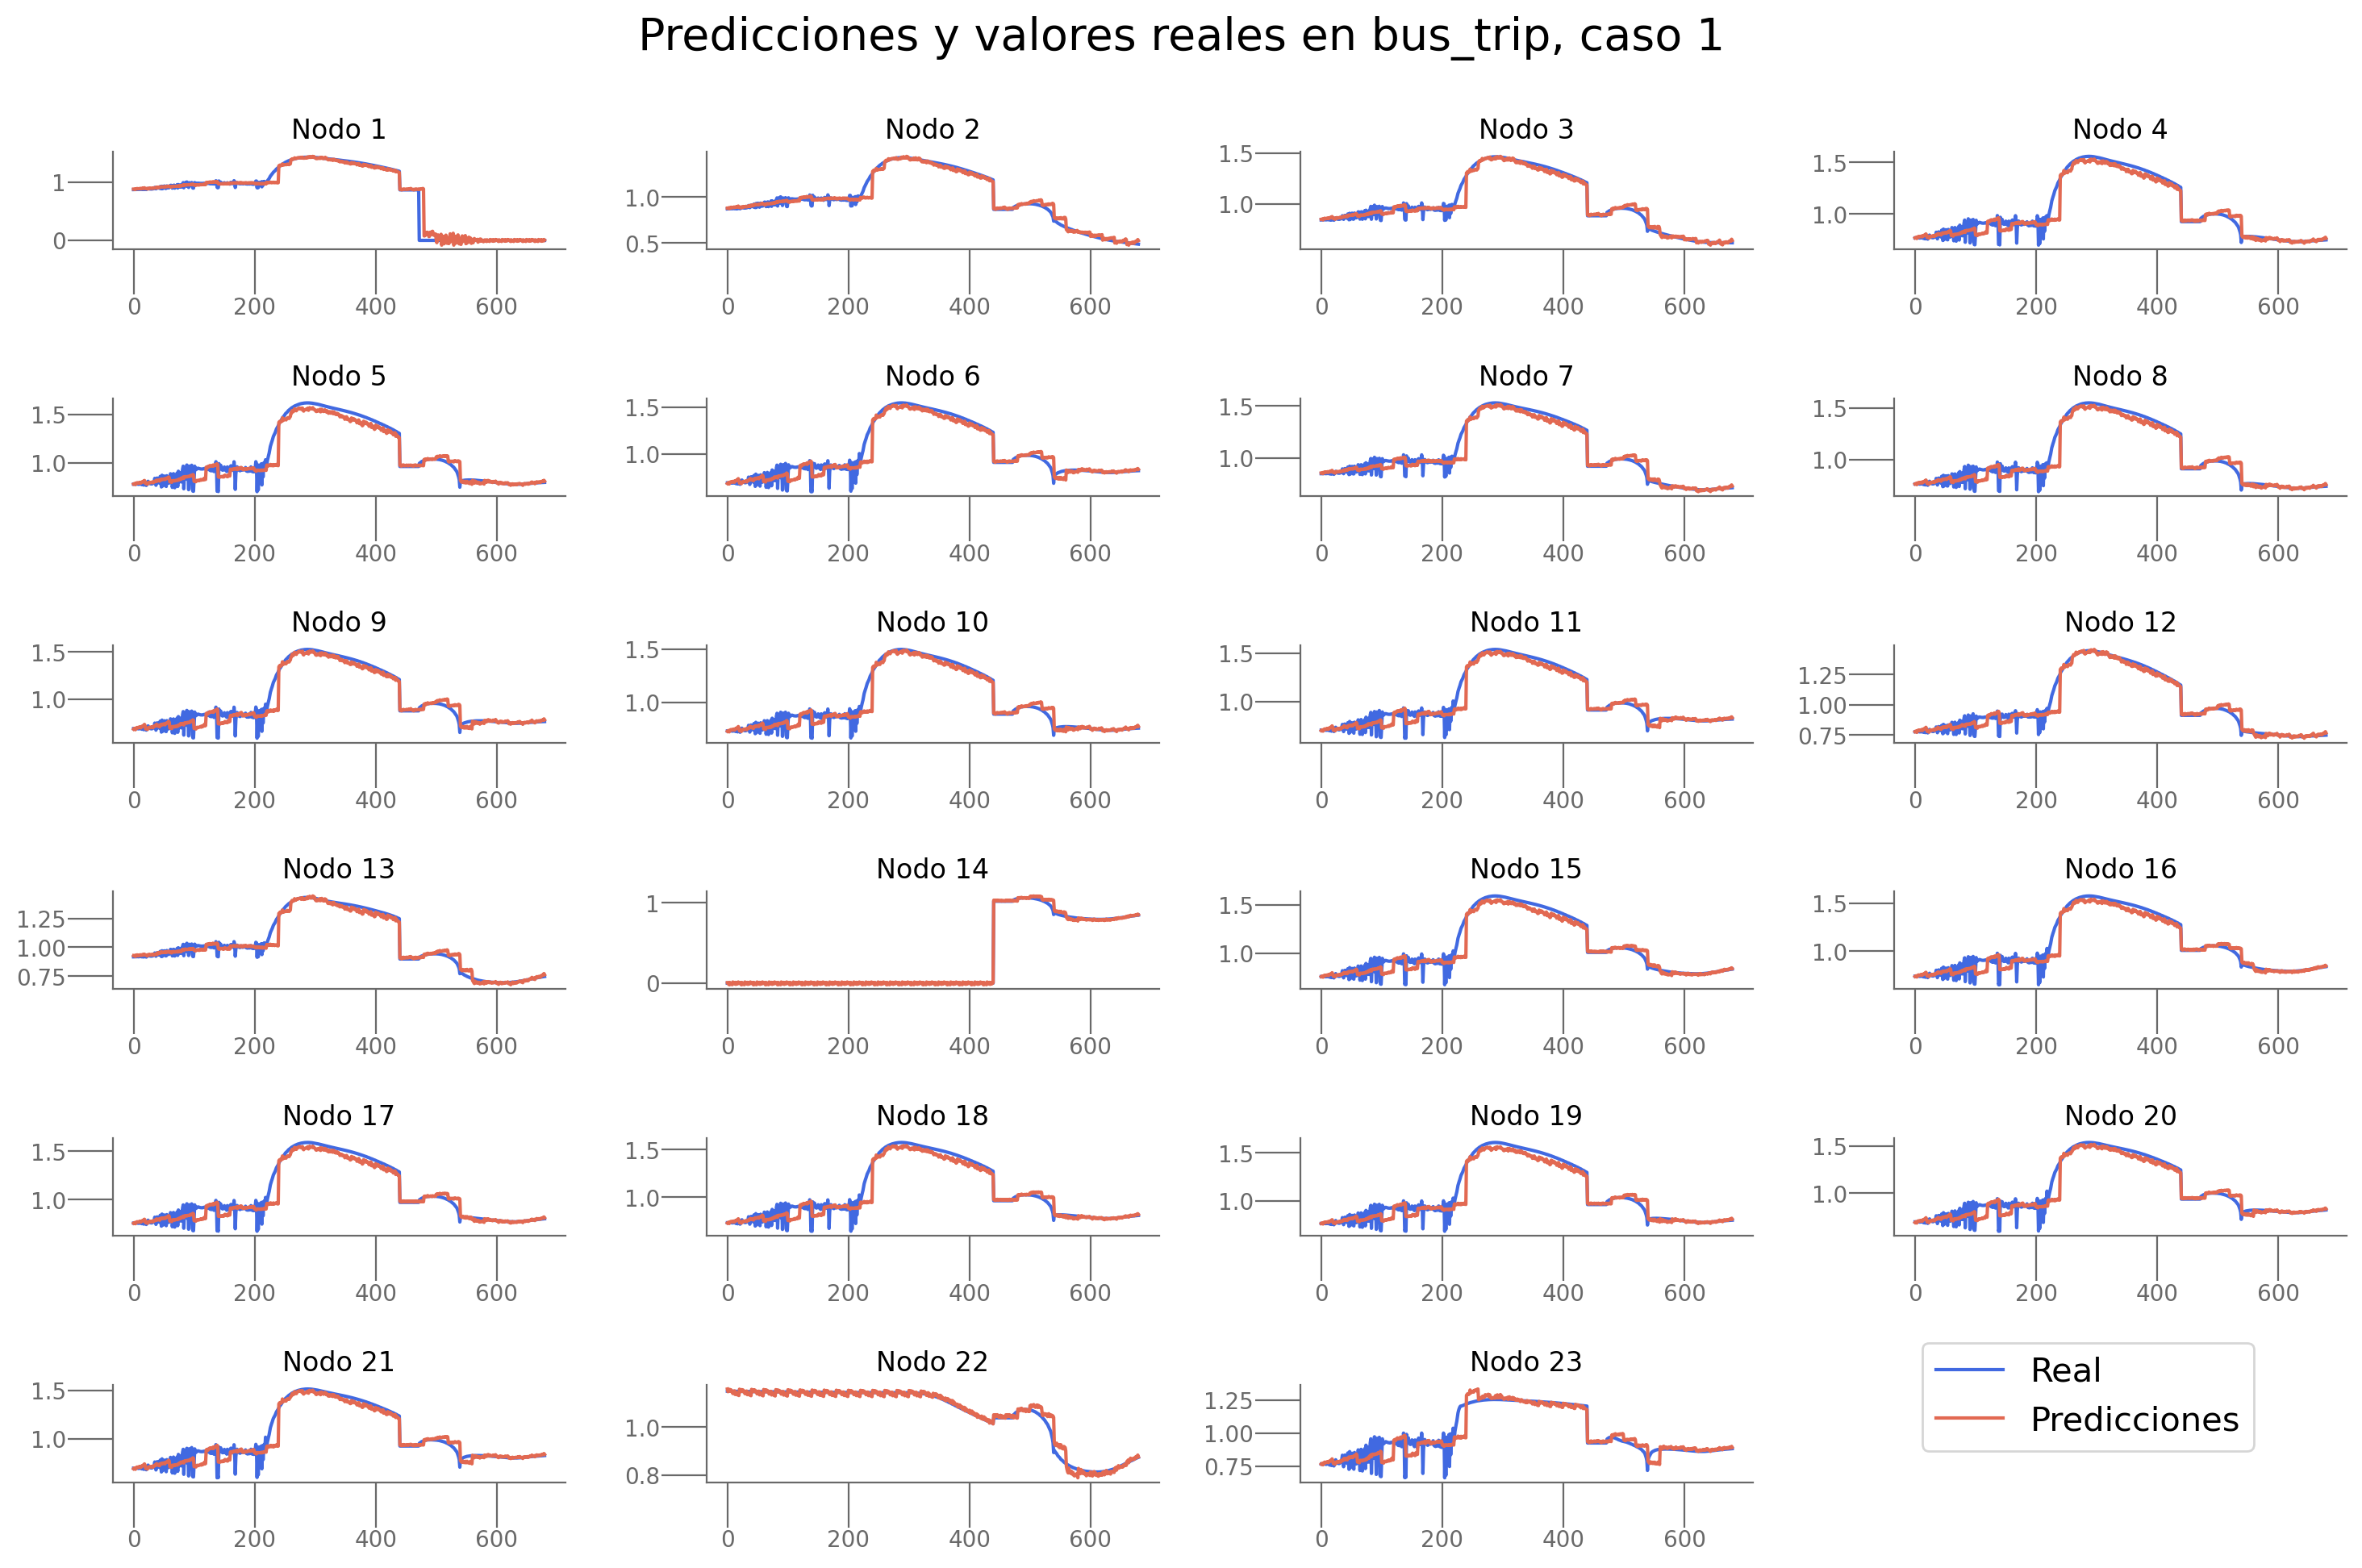

In [37]:
_,_,_, predictions_bt_ajuste,real_bt_ajuste = trainer_bt.test()
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 1, n_div_bt, problem_bt)

In [49]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params = params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6         DCRNN                                     {'hidden': 60}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3  ./results/bus_trip/ajustes/DryGrEncoder_result...  0.005348  0.82743

### Bus fault

In [50]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [52]:

n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [53]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_bf,params_bf, resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.3603 | Eval Loss: 0.2467 | Eval R2: -67.9345 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.1820 | Eval Loss: 0.1408 | Eval R2: -35.5907 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.1082 | Eval Loss: 0.0960 | Eval R2: -20.4514 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0753 | Eval Loss: 0.0741 | Eval R2: -13.2435 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0581 | Eval Loss: 0.0611 | Eval R2: -9.5756 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0479 | Eval Loss: 0.0530 | Eval R2: -7.6586 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0414 | Eval Loss: 0.0482 | Eval R2: -6.7970 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0371 | Eval Loss: 0.0451 | Eval R2: -6.2856 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0339 | Eval Loss: 0.0420 | Eval R2: -5.6477 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0314 | Eval L

 25%|██▌       | 1/4 [01:26<04:18, 86.04s/it]

preds:  (1, 23, 20)
test loss: 0.017937, test R2 score: -1.258134
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.01854655332863331, 'R2_eval': -2.8099870681762695, 'Loss_eval': 0.02614775113761425, 'R2_tst': -1.258133558717593, 'Loss_tst': 0.017936665564775467, 'Loss_nodes': [[0.005709188990294933, 0.00766111770644784, 0.007956353016197681, 0.00955013558268547, 0.012311684899032116, 0.0101145189255476, 0.0149203110486269, 0.01813565380871296, 0.01724550500512123, 0.01724078319966793, 0.0213618203997612, 0.021428711712360382, 0.025088205933570862, 0.023601487278938293, 0.024064049124717712, 0.02101823501288891, 0.024921663105487823, 0.025139842182397842, 0.024579742923378944, 0.026684274896979332]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.3499 | Eval Loss: 0.2225 | Eval R2: -61.8277 | LR: 0.0010 | 
Epoch 2/50 | Tra

 50%|█████     | 2/4 [02:48<02:48, 84.19s/it]

preds:  (1, 23, 20)
test loss: 0.017845, test R2 score: -1.287120
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.01857822760939598, 'R2_eval': -2.8381426334381104, 'Loss_eval': 0.025824543088674545, 'R2_tst': -1.2871202634537573, 'Loss_tst': 0.017845159396529198, 'Loss_nodes': [[0.006133874412626028, 0.0075325206853449345, 0.008235420100390911, 0.008876695297658443, 0.009791459888219833, 0.01169562991708517, 0.015455965884029865, 0.014987069182097912, 0.017451142892241478, 0.017772817984223366, 0.019377514719963074, 0.021551411598920822, 0.023284388706088066, 0.02500852569937706, 0.025348754599690437, 0.02263086475431919, 0.024704745039343834, 0.024710100144147873, 0.02521209791302681, 0.027142232283949852]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.2399 | Eval Loss: 0.1106 | Eval R2: -20.0677 | LR: 0.0010 | 
Epoch

 75%|███████▌  | 3/4 [04:18<01:26, 86.52s/it]

preds:  (1, 23, 20)
test loss: 0.016295, test R2 score: -0.827346
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.01797596924006939, 'R2_eval': -2.3843233585357666, 'Loss_eval': 0.02471904270350933, 'R2_tst': -0.8273464550130717, 'Loss_tst': 0.01629474200308323, 'Loss_nodes': [[0.003982333932071924, 0.0064249057322740555, 0.006531785242259502, 0.008023642934858799, 0.009671512059867382, 0.009038455784320831, 0.012868255376815796, 0.01413235068321228, 0.01577676832675934, 0.016310280188918114, 0.01746145449578762, 0.02111201360821724, 0.02377409115433693, 0.022061552852392197, 0.023862488567829132, 0.021263133734464645, 0.022160612046718597, 0.025343500077724457, 0.022113092243671417, 0.023982590064406395]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.1736 | Eval Loss: 0.0870 | Eval R2: -10.7509 | LR: 0.0010 | 
Epoch 2/

100%|██████████| 4/4 [06:23<00:00, 95.93s/it] 

preds:  (1, 23, 20)
test loss: 0.016591, test R2 score: -0.870035
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.017677852883934975, 'R2_eval': -2.310422897338867, 'Loss_eval': 0.02449885569512844, 'R2_tst': -0.8700353467201102, 'Loss_tst': 0.016591185703873634, 'Loss_nodes': [[0.004875965416431427, 0.005500371567904949, 0.0067552803084254265, 0.008078126236796379, 0.00924494955688715, 0.009991149418056011, 0.013340150937438011, 0.01449217926710844, 0.01625026762485504, 0.01653802953660488, 0.017889298498630524, 0.021092452108860016, 0.0238740723580122, 0.02245444990694523, 0.024119772017002106, 0.021818114444613457, 0.022338084876537323, 0.025516333058476448, 0.022768357768654823, 0.02488628961145878]]}


In [60]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.016295, test R2 score: -0.827346


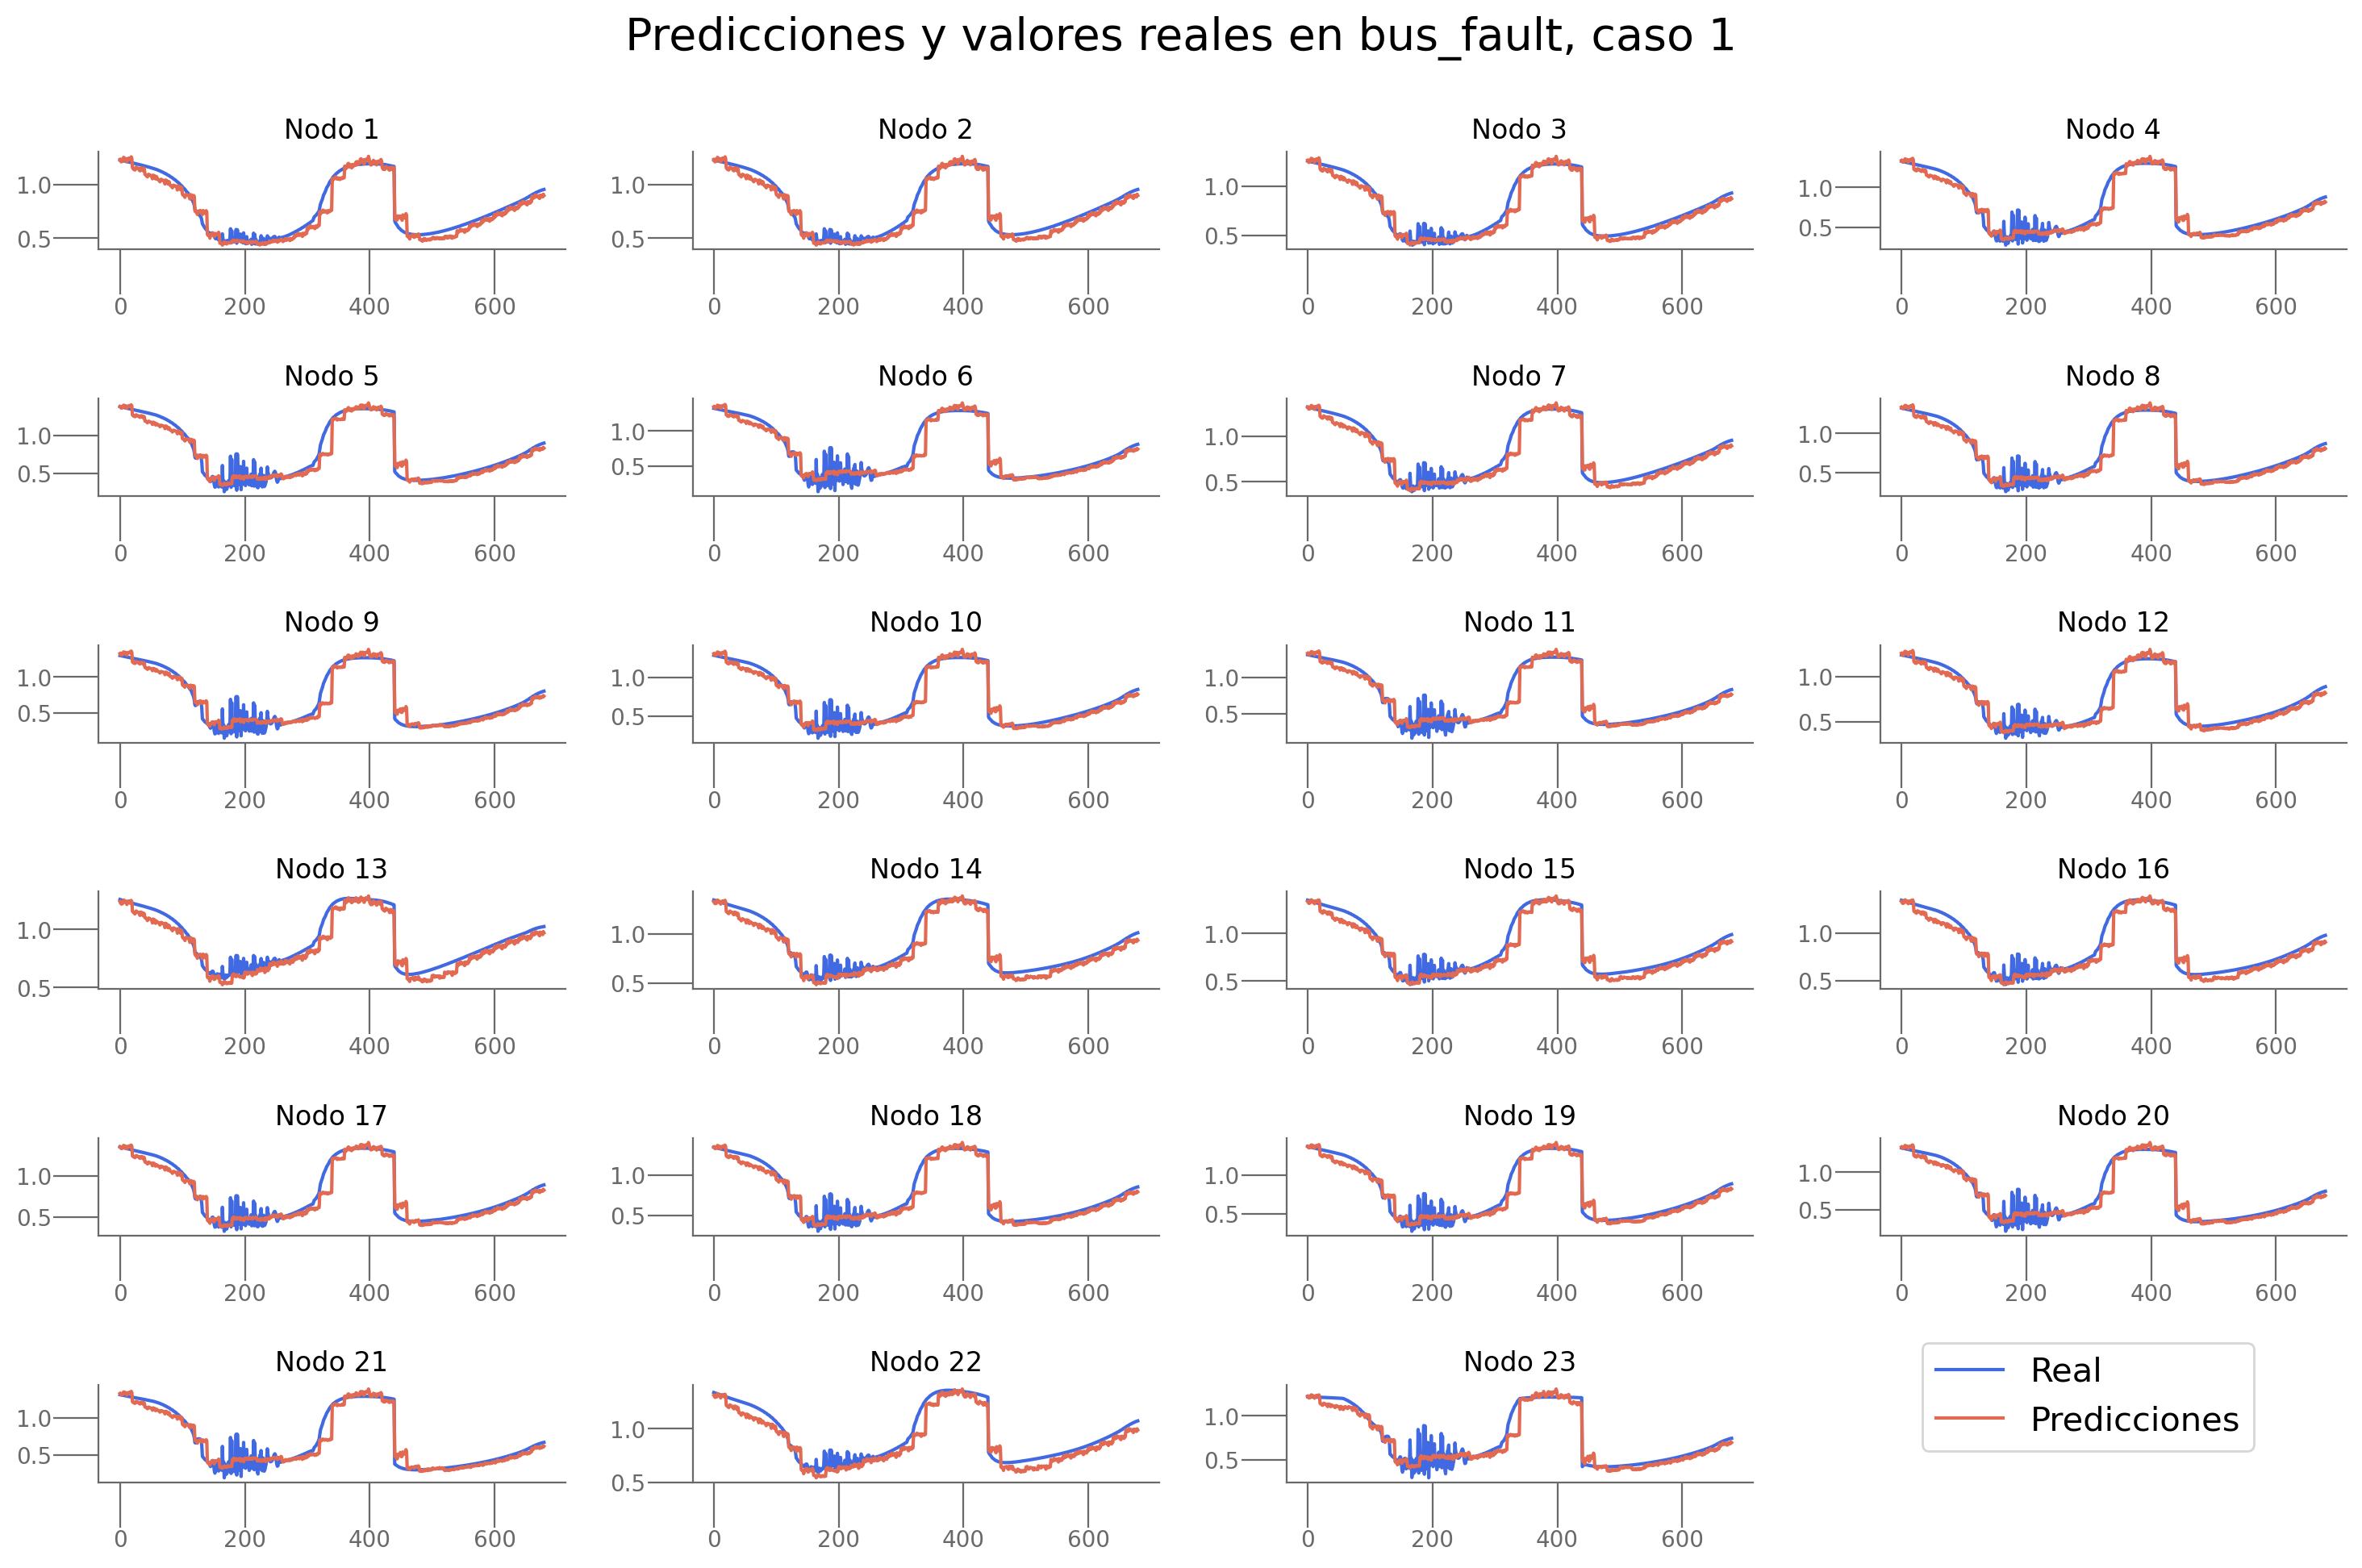

In [55]:
_,_,_, predictions_bf_ajuste,real_bf_ajuste = trainer_bf.test()
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 1, n_div_bf, problem_bf)

In [56]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params = params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6         DCRNN                                     {'hidden': 40}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.66477

### Branch Fault

In [61]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [62]:

n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [63]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_brf,params_brf, resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.2816 | Eval Loss: 0.2525 | Eval R2: -29.6602 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.1411 | Eval Loss: 0.1524 | Eval R2: -17.8186 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.0893 | Eval Loss: 0.1103 | Eval R2: -12.4620 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0673 | Eval Loss: 0.0882 | Eval R2: -9.5828 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0551 | Eval Loss: 0.0737 | Eval R2: -7.6184 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0473 | Eval Loss: 0.0641 | Eval R2: -6.2580 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0423 | Eval Loss: 0.0576 | Eval R2: -5.4086 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0387 | Eval Loss: 0.0523 | Eval R2: -4.8574 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0358 | Eval Loss: 0.0479 | Eval R2: -4.4901 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0333 | Eval Lo

 25%|██▌       | 1/4 [03:27<10:21, 207.20s/it]

preds:  (1, 23, 20)
test loss: 0.021258, test R2 score: -1.532355
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.02052116207778454, 'R2_eval': -2.8215601444244385, 'Loss_eval': 0.027635090053081512, 'R2_tst': -1.532354925674204, 'Loss_tst': 0.02125818096101284, 'Loss_nodes': [[0.0053937979973852634, 0.007437874563038349, 0.010700861923396587, 0.014469178393483162, 0.011905543506145477, 0.012748225592076778, 0.01596192456781864, 0.02173297107219696, 0.02291378751397133, 0.019921179860830307, 0.02104533463716507, 0.022653425112366676, 0.02852071262896061, 0.029980922117829323, 0.027231264859437943, 0.026758303865790367, 0.030422968789935112, 0.030733218416571617, 0.0350823812186718, 0.029549749568104744]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.2680 | Eval Loss: 0.2351 | Eval R2: -27.9182 | LR: 0.0010 | 
Epoch 2/50

 50%|█████     | 2/4 [05:47<05:35, 167.95s/it]

preds:  (1, 23, 20)
test loss: 0.021033, test R2 score: -1.501369
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.020321177318692207, 'R2_eval': -2.8591368198394775, 'Loss_eval': 0.027965296059846878, 'R2_tst': -1.5013686200850016, 'Loss_tst': 0.02103267051279545, 'Loss_nodes': [[0.004793275613337755, 0.007440220098942518, 0.011059465818107128, 0.013508462347090244, 0.011533437296748161, 0.012776656076312065, 0.015526775270700455, 0.021224841475486755, 0.023556970059871674, 0.02009180560708046, 0.01991856098175049, 0.02223835699260235, 0.027209540829062462, 0.031069528311491013, 0.02675280161201954, 0.026439009234309196, 0.029400775209069252, 0.031014971435070038, 0.03511077165603638, 0.029987167567014694]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.1874 | Eval Loss: 0.1246 | Eval R2: -14.0877 | LR: 0.0010 | 
Epoch 2

 75%|███████▌  | 3/4 [07:20<02:13, 133.52s/it]

preds:  (1, 23, 20)
test loss: 0.020633, test R2 score: -1.673739
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.019574709236621857, 'R2_eval': -3.019313335418701, 'Loss_eval': 0.0275303665548563, 'R2_tst': -1.6737386980009912, 'Loss_tst': 0.020632537081837654, 'Loss_nodes': [[0.004514304455369711, 0.007615461479872465, 0.010385600849986076, 0.01347176730632782, 0.010872362181544304, 0.012807759456336498, 0.015443048439919949, 0.020841509103775024, 0.02326003648340702, 0.01972706988453865, 0.01991160772740841, 0.022341912612318993, 0.028560075908899307, 0.028883105143904686, 0.026379350572824478, 0.02618752419948578, 0.02870912477374077, 0.031313706189394, 0.03296522796154022, 0.028460152447223663]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.1454 | Eval Loss: 0.1025 | Eval R2: -11.1548 | LR: 0.0010 | 
Epoch 2/50 | T

100%|██████████| 4/4 [08:54<00:00, 133.62s/it]

preds:  (1, 23, 20)
test loss: 0.020181, test R2 score: -1.579962
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.019600117579102516, 'R2_eval': -2.920274019241333, 'Loss_eval': 0.026817740872502327, 'R2_tst': -1.5799622820619454, 'Loss_tst': 0.020180746912956238, 'Loss_nodes': [[0.004139141645282507, 0.007751500234007835, 0.009830120950937271, 0.012380585074424744, 0.010832001455128193, 0.012388236820697784, 0.015841523185372353, 0.01878977380692959, 0.02190423384308815, 0.01983872801065445, 0.020142503082752228, 0.02260681428015232, 0.027032876387238503, 0.028491484001278877, 0.02584664523601532, 0.025380857288837433, 0.029007866978645325, 0.02970915287733078, 0.033049922436475754, 0.028651006519794464]]}


In [ ]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.024755, test r2score 0.589204


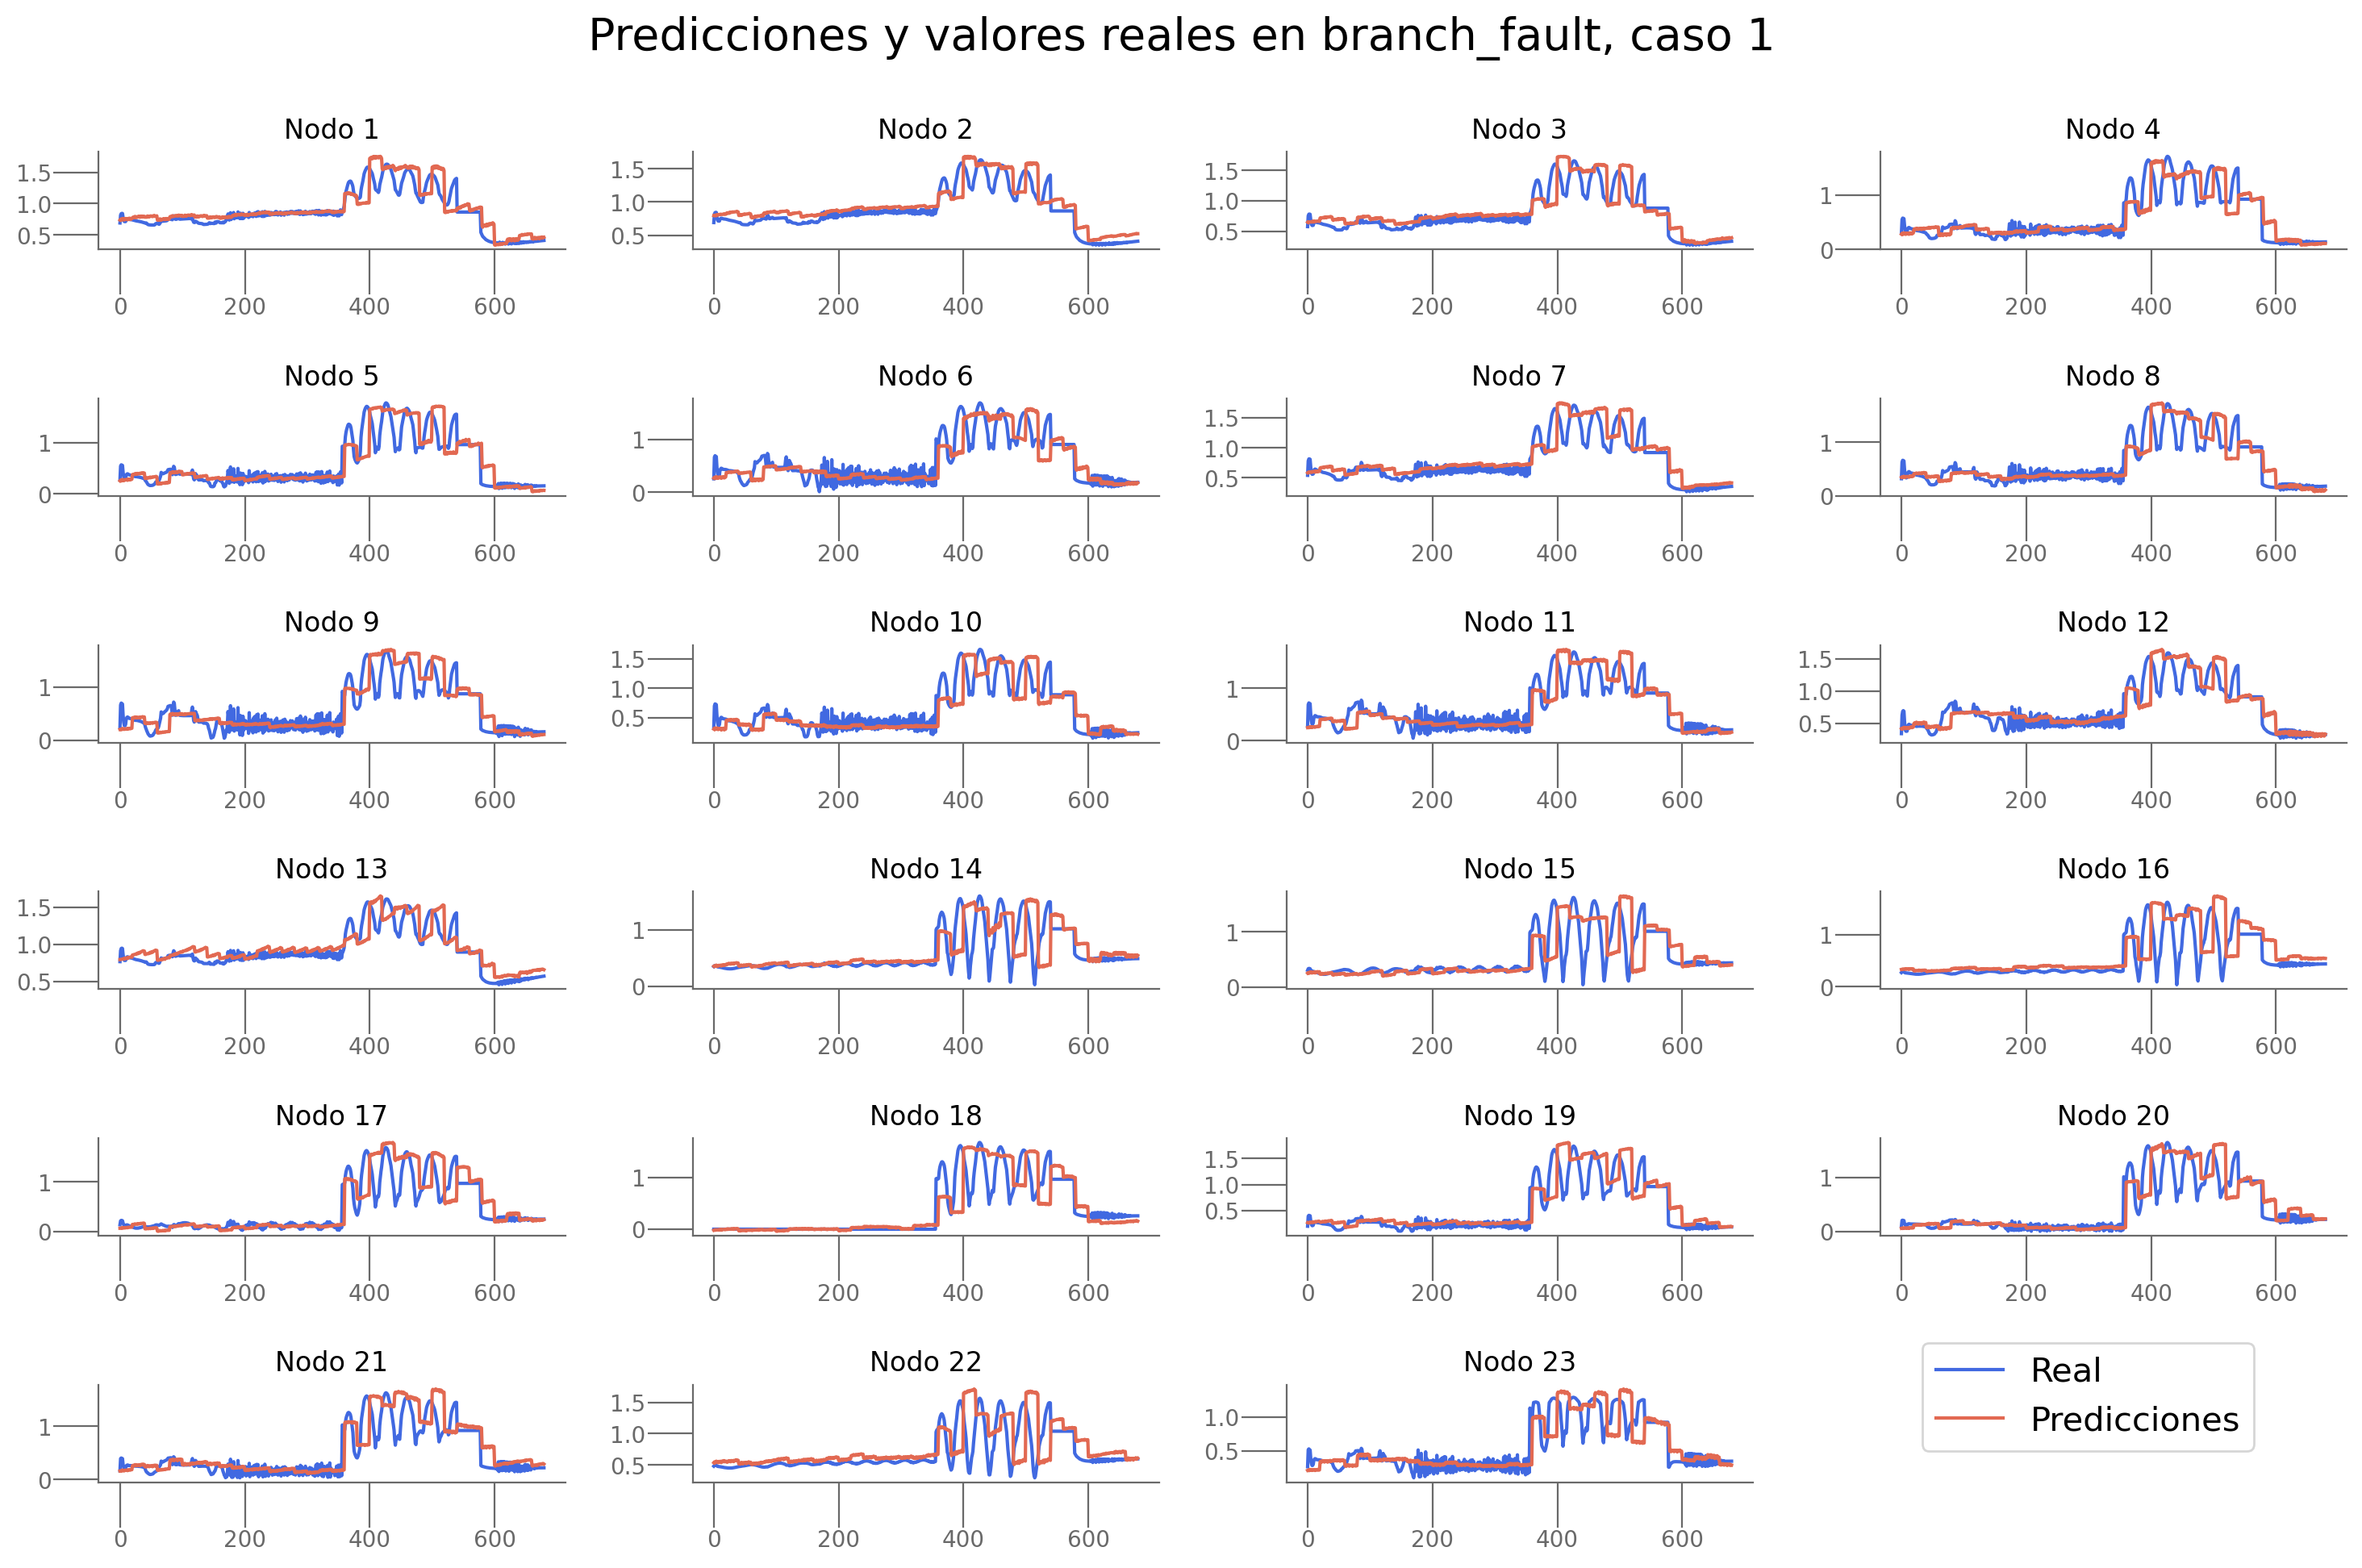

In [ ]:
_,_,_, predictions_brf_ajuste,real_brf_ajuste = trainer_brf.test()
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 1, n_div_brf, problem_brf)

In [ ]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params = params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM    {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.565135   
4   ./results/branch_fault/ajustes/AGCRN_results.csv  0.024755  0.589204   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01155095 0.00907443 0.01350776 0.02466182 0... 

### Branch trip

In [ ]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [ ]:

n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [ ]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_brt,params_brt, resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 477
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 101

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1039 | Eval Loss: 0.0263 | Eval R2: -4.4288 | 
Epoch 2/30 | Train Loss: 0.0171 | Eval Loss: 0.0185 | Eval R2: -3.8461 | 
Epoch 3/30 | Train Loss: 0.0115 | Eval Loss: 0.0153 | Eval R2: -3.6809 | 
Epoch 4/30 | Train Loss: 0.0095 | Eval Loss: 0.0116 | Eval R2: -2.2078 | 
Epoch 5/30 | Train Loss: 0.0087 | Eval Loss: 0.0121 | Eval R2: -2.5162 | 
Epoch 6/30 | Train Loss: 0.0079 | Eval Loss: 0.0095 | Eval R2: -1.4901 | 
Epoch 7/30 | Train Loss: 0.0073 | Eval Loss: 0.0093 | Eval R2: -1.5203 | 
Epoch 8/30 | Train Loss: 0.0068 | Eval Loss: 0.0095 | Eval R2: -1.6170 | 
Epoch 9/30 | Train Loss: 0.0065 |

 11%|█         | 1/9 [02:54<23:17, 174.74s/it]

preds:  (5, 23, 20)
test loss: 0.005193, test r2score -0.096764
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.004496000707149506, 'R2_eval': -0.12752766907215118, 'Loss_eval': 0.004977001808583736, 'R2_tst': -0.09676406402959689, 'Loss_tst': 0.005193374119699001, 'Loss_nodes': [0.0037031748797744513, 0.0036374228075146675, 0.003515842603519559, 0.004238395020365715, 0.005206141155213118, 0.006780348252505064, 0.004442285746335983, 0.0045212204568088055, 0.007452973164618015, 0.005981736350804567, 0.005924818571656942, 0.0051582264713943005, 0.004907643422484398, 0.0036704090889543295, 0.006445098668336868, 0.005974407307803631, 0.004964201245456934, 0.008438645862042904, 0.0045044138096272945, 0.004176540765911341, 0.00817182008177042, 0.003537682117894292, 0.004094146192073822]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoa

 22%|██▏       | 2/9 [06:05<21:27, 183.96s/it]

preds:  (5, 23, 20)
test loss: 0.008110, test r2score -1.103023
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.005572865251451731, 'R2_eval': -1.1811234951019287, 'Loss_eval': 0.007726946845650673, 'R2_tst': -1.1030228751505553, 'Loss_tst': 0.00810983031988144, 'Loss_nodes': [0.004741321783512831, 0.0069716027937829494, 0.007235827390104532, 0.013322671875357628, 0.008784525096416473, 0.00792824849486351, 0.011159412562847137, 0.005848507862538099, 0.008226532489061356, 0.014619240537285805, 0.007377046160399914, 0.005436270497739315, 0.006428731605410576, 0.0059049720875918865, 0.004604500252753496, 0.009180037304759026, 0.00604740995913744, 0.006580682005733252, 0.005955578293651342, 0.006869317963719368, 0.012733065523207188, 0.003659209469333291, 0.016911381855607033]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 33%|███▎      | 3/9 [09:30<19:23, 193.91s/it]

preds:  (5, 23, 20)
test loss: 0.008367, test r2score -0.786422
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.0066592274233698845, 'R2_eval': -0.46901583671569824, 'Loss_eval': 0.006838085129857063, 'R2_tst': -0.7864223164771827, 'Loss_tst': 0.008366678841412067, 'Loss_nodes': [0.004244586918503046, 0.003849639557301998, 0.010907483287155628, 0.015371393412351608, 0.007893548347055912, 0.009874599054455757, 0.0069445357657969, 0.008161480538547039, 0.01247471384704113, 0.012139257974922657, 0.010022594593465328, 0.005718781612813473, 0.008447857573628426, 0.0038848919793963432, 0.00752874044701457, 0.007491670083254576, 0.007467986550182104, 0.008588314056396484, 0.00851619616150856, 0.00998412724584341, 0.01123123150318861, 0.005162155255675316, 0.006527844816446304]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for tra

 44%|████▍     | 4/9 [12:25<15:31, 186.39s/it]

preds:  (5, 23, 20)
test loss: 0.009734, test r2score -1.492104
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.006212989334017038, 'R2_eval': -1.3237159252166748, 'Loss_eval': 0.008915950544178486, 'R2_tst': -1.4921037887735518, 'Loss_tst': 0.009733883664011955, 'Loss_nodes': [0.006718445103615522, 0.00274180737324059, 0.008408295921981335, 0.007887765765190125, 0.007870045490562916, 0.01481745857745409, 0.008380119688808918, 0.008042371831834316, 0.010311825200915337, 0.011861583217978477, 0.02326980233192444, 0.020930934697389603, 0.005908753722906113, 0.008293417282402515, 0.010684380307793617, 0.008495114743709564, 0.007861790247261524, 0.006472265813499689, 0.009217629209160805, 0.016878265887498856, 0.009593523107469082, 0.005035777576267719, 0.004197961650788784]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 56%|█████▌    | 5/9 [15:41<12:39, 189.90s/it]

preds:  (5, 23, 20)
test loss: 0.008397, test r2score -0.606775
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.007256035227328539, 'R2_eval': -0.25769108533859253, 'Loss_eval': 0.006815391592681408, 'R2_tst': -0.6067749287140065, 'Loss_tst': 0.008397315628826618, 'Loss_nodes': [0.00496940640732646, 0.004971473943442106, 0.007318271789699793, 0.008836316876113415, 0.029942292720079422, 0.009564769454300404, 0.007067775819450617, 0.008362337946891785, 0.009532888419926167, 0.00802020076662302, 0.008527757599949837, 0.006410638801753521, 0.005062834359705448, 0.005331301596015692, 0.006473786663264036, 0.005568324122577906, 0.009165272116661072, 0.006510801613330841, 0.008635474368929863, 0.01158791221678257, 0.007727241609245539, 0.004620675463229418, 0.008930502459406853]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for

 67%|██████▋   | 6/9 [19:14<09:53, 197.70s/it]

preds:  (5, 23, 20)
test loss: 0.010753, test r2score -1.710344
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.00849840696901083, 'R2_eval': -1.4203647375106812, 'Loss_eval': 0.00981492642313242, 'R2_tst': -1.7103436171701751, 'Loss_tst': 0.010752571746706963, 'Loss_nodes': [0.007958916015923023, 0.005501583218574524, 0.020177189260721207, 0.013476653024554253, 0.007604799699038267, 0.010871944949030876, 0.013204327784478664, 0.01231098547577858, 0.013387941755354404, 0.01101470086723566, 0.013711713254451752, 0.007883760146796703, 0.00878839660435915, 0.01176250446587801, 0.008009754121303558, 0.007024358492344618, 0.011353818699717522, 0.011461415328085423, 0.018425878137350082, 0.010375984013080597, 0.010783783160150051, 0.006868184078484774, 0.0053505371324718]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train

 78%|███████▊  | 7/9 [22:11<06:21, 190.73s/it]

preds:  (5, 23, 20)
test loss: 0.010059, test r2score -1.927895
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.0072896480560302734, 'R2_eval': -1.6100001335144043, 'Loss_eval': 0.009433050639927387, 'R2_tst': -1.9278947058222444, 'Loss_tst': 0.010059420019388199, 'Loss_nodes': [0.00989703182131052, 0.006558045279234648, 0.005517582409083843, 0.013415544293820858, 0.010063095018267632, 0.009088224731385708, 0.02305193431675434, 0.007986762560904026, 0.009984245523810387, 0.009839097037911415, 0.009290145710110664, 0.008525791577994823, 0.006553086452186108, 0.006107791792601347, 0.011329366825520992, 0.014682316221296787, 0.008902995847165585, 0.013949554413557053, 0.010321431793272495, 0.008743366226553917, 0.008141960017383099, 0.005644226912409067, 0.013773049227893353]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader fo

 89%|████████▉ | 8/9 [25:37<03:15, 195.62s/it]

preds:  (5, 23, 20)
test loss: 0.010947, test r2score -2.034323
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.007962399162352085, 'R2_eval': -1.7177425622940063, 'Loss_eval': 0.010102340951561928, 'R2_tst': -2.0343234956000043, 'Loss_tst': 0.010946888476610184, 'Loss_nodes': [0.008576943539083004, 0.004135483875870705, 0.015300564467906952, 0.010312780737876892, 0.019026117399334908, 0.011903638951480389, 0.008194957859814167, 0.017937030643224716, 0.01738550327718258, 0.008917654864490032, 0.014411957003176212, 0.02240350842475891, 0.006857280619442463, 0.006314105354249477, 0.00816672295331955, 0.005762184504419565, 0.010520277544856071, 0.01178673841059208, 0.0111631965264678, 0.009711752645671368, 0.00803329423069954, 0.006265966687351465, 0.008690795861184597]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for trai

100%|██████████| 9/9 [29:10<00:00, 194.48s/it]

preds:  (5, 23, 20)
test loss: 0.010984, test r2score -1.334377
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.009647582657635212, 'R2_eval': -1.0036756992340088, 'Loss_eval': 0.009405278600752354, 'R2_tst': -1.3343771081212012, 'Loss_tst': 0.010984028689563274, 'Loss_nodes': [0.005802441854029894, 0.0035407550167292356, 0.01251694094389677, 0.009635771624743938, 0.012332482263445854, 0.017229745164513588, 0.006673772353678942, 0.010664599016308784, 0.011022882536053658, 0.015237619169056416, 0.00928699690848589, 0.006911368574947119, 0.03165661543607712, 0.008787846192717552, 0.008166436105966568, 0.009269670583307743, 0.008404187858104706, 0.009819135069847107, 0.0139154102653265, 0.010421399027109146, 0.013617492280900478, 0.007976989261806011, 0.009742114692926407]}


In [ ]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.005193, test r2score -0.096764


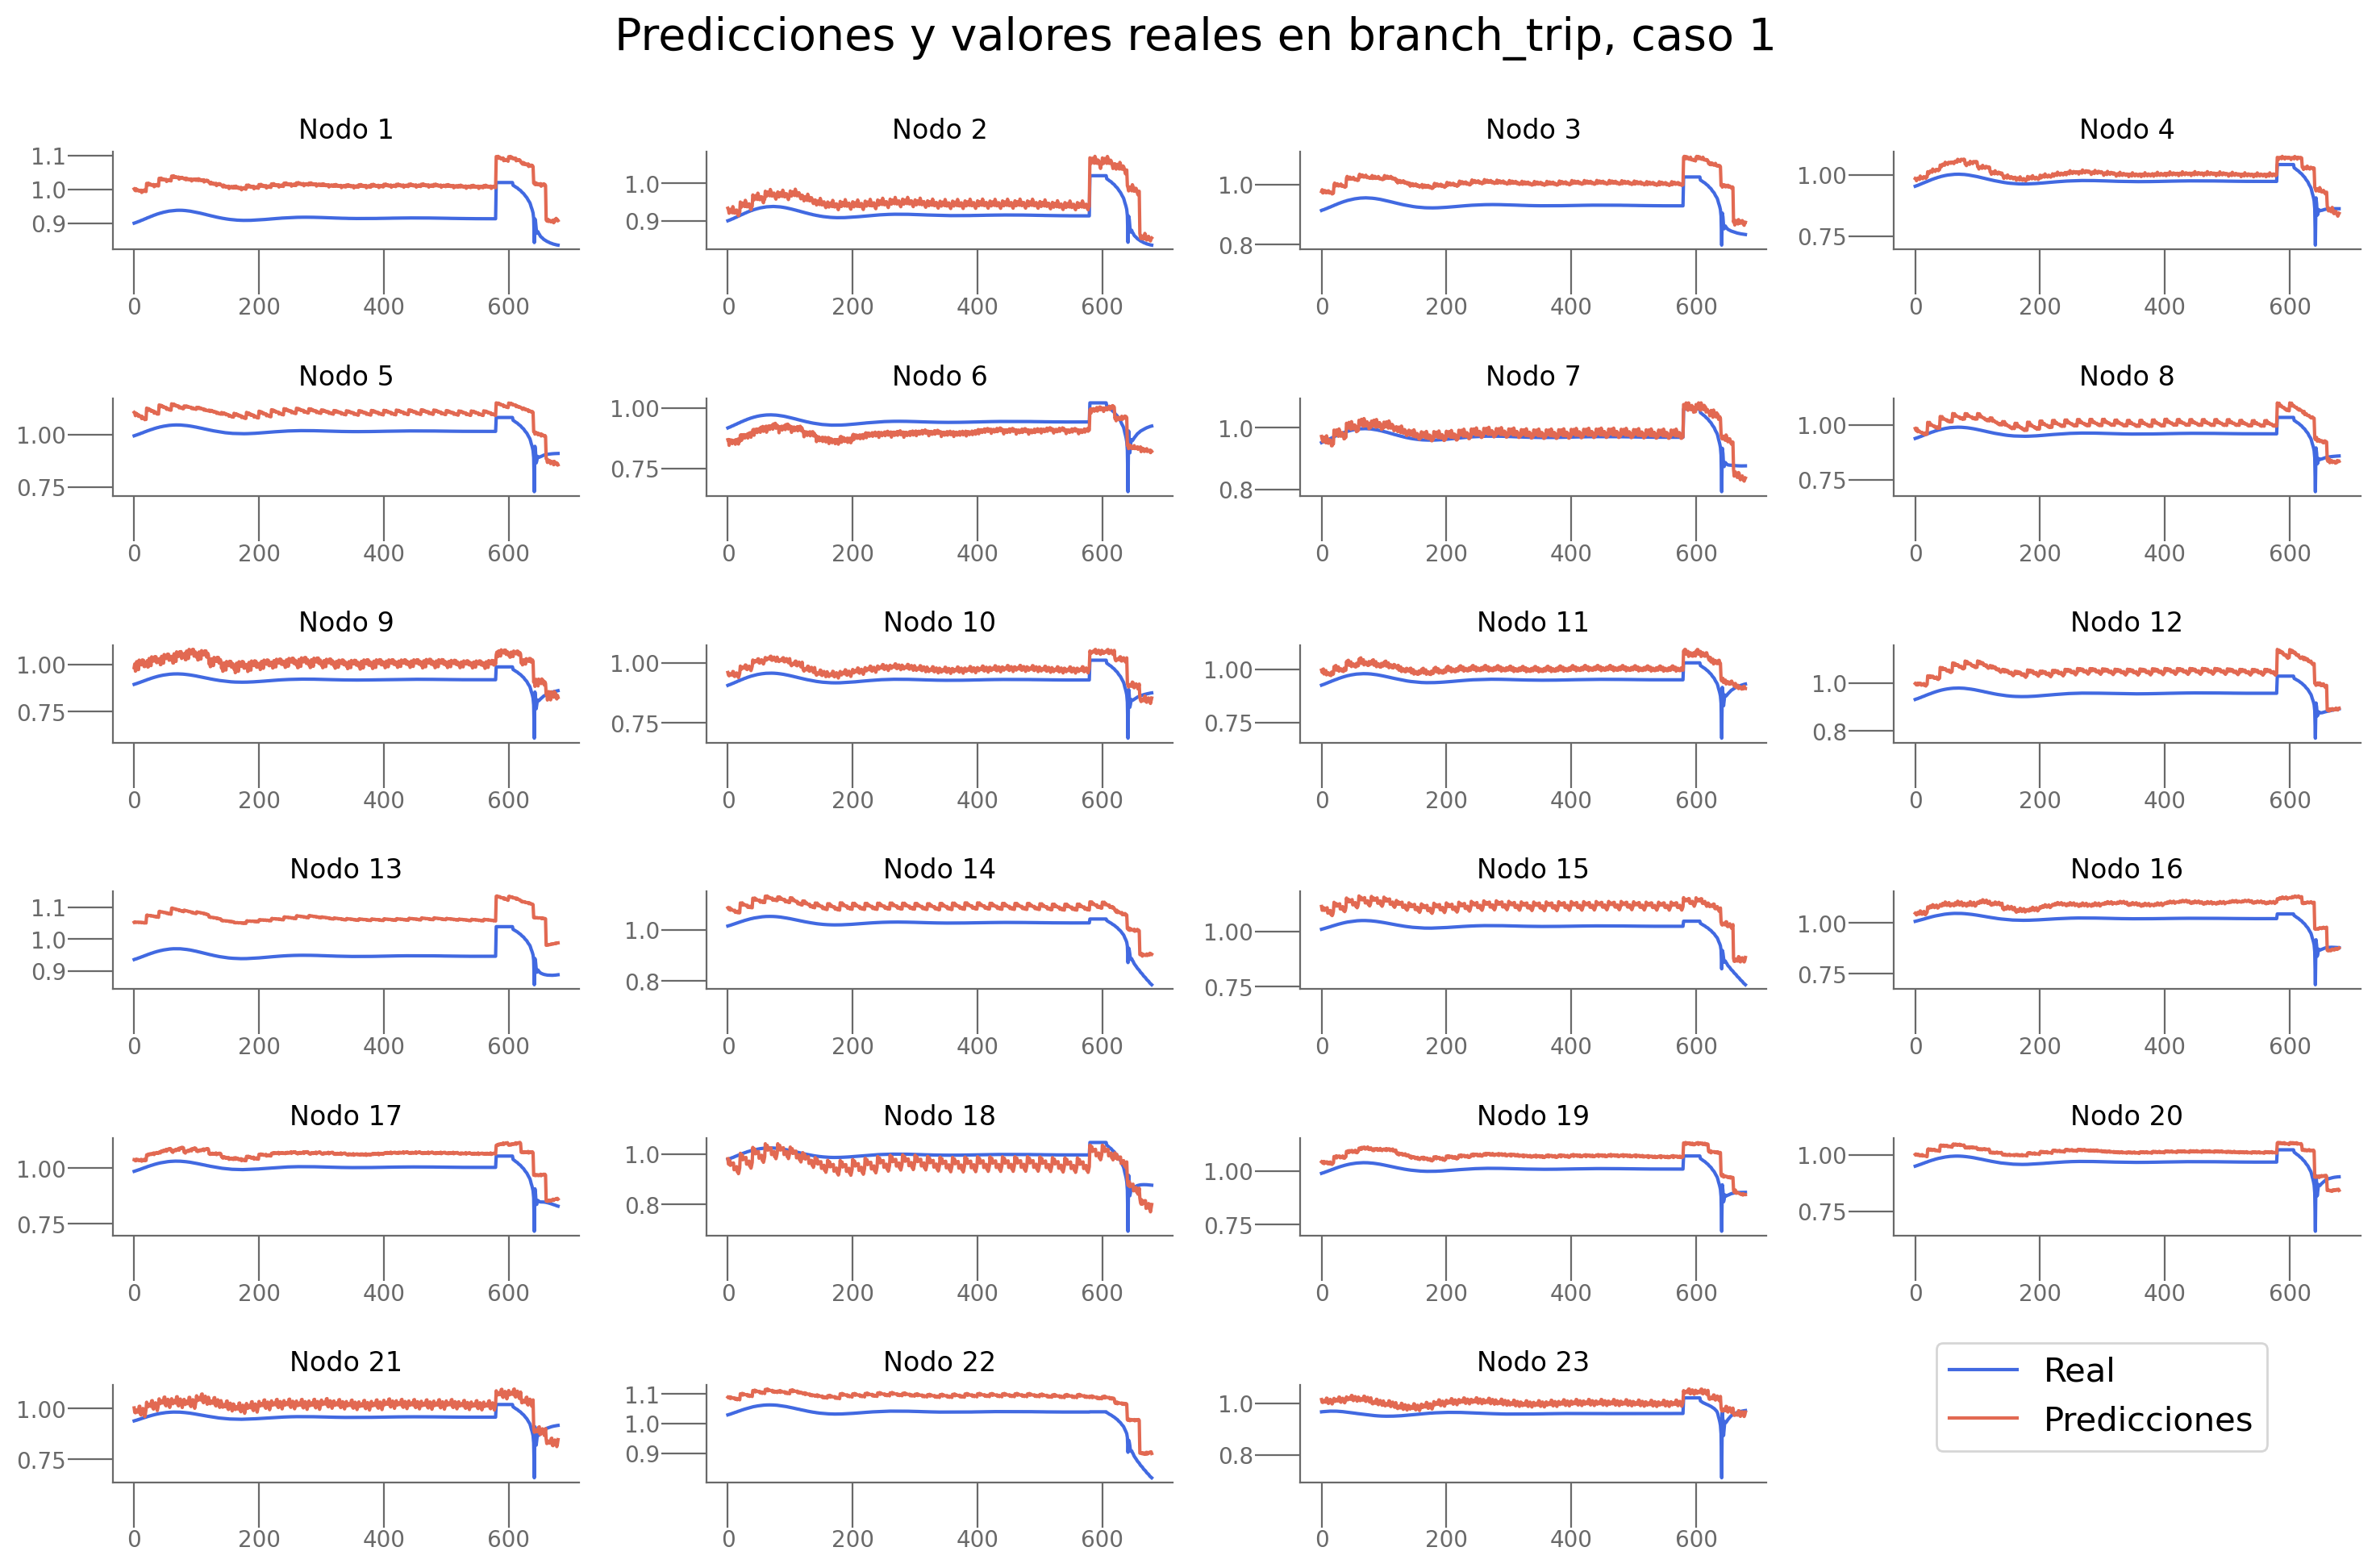

In [ ]:
_,_,_, predictions_brt_ajuste,real_brt_ajuste = trainer_brt.test()
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [ ]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params = params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM    {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3  ./results/branch_trip/ajustes/MPNNLSTM_results...  0.004205 -1.453302   
4    ./results/branch_trip/ajustes/AGCRN_results.csv  0.005193 -0.096764   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0036937  0.00202668 0.00244704 0.00374463 0... 